# Bisection for sGA solving OneMax and Trap-5

## Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import math

## Mounting Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## Basic function for POPOP

In [84]:
def initialize_population(num_individuals, num_variables) :
    '''

    Function for initializing new population

    Arguments:
    num_individuals: number of individuals you want in the population
    num_variables: number of variables in a single individuals

    Return:
    A new population with size (num_individuals, num_variables)

    '''
    # Function for randomly initialize population using 2 parameters
    return np.random.randint(2, size = (int(num_individuals), int(num_variables)))

In [85]:
def onemax(ind):
    '''
    Function for calculating fitness of onemax function
    Argument:
    ind: individual for calculating

    Return:
    value: value account for that ind

    '''
    value = np.sum(ind)
    return value

def trap_k(ind, k = 5):
    '''
    Function for calculating fitness for trap function
    Arguments:
    ind: individual for calculating
    k: length of the traps

    Return:
    value: value account for that ind
    '''
    num_traps = len(ind) // k
    value = 0
    for i in range(0, num_traps):
        temp = np.sum(ind[i*k : i*k+k])
        if temp == k:
            value += temp
        else: 
            value += k - 1 - temp
    return value

In [86]:
def evaluate_population(pop, trap = False, len_traps = 5):
    '''

    Use to evaluate fitness of all ind in pop
    Arguments: 
    pop: The initialized population
    trap: Boolean value. If == True then it will use trap fitness function
    len_traps: length of a trap. Need to be assigned if trap == True

    Return:
    values: an array account for all value of individuals' fitness

    '''
    if trap == False:
        values = np.array([onemax(ind) for ind in pop])
    else:
        values = np.array([trap_k(ind, k = len_traps) for ind in pop])
    return values


In [87]:
def better_fitness(fitness_1, fitness_2, maximization=True):
    if maximization:
        if fitness_1 > fitness_2:
            return True
    else:
        if fitness_1 < fitness_2:
            return True
    return False

### Calculate MDL for better grouping


In [88]:
from itertools import product
import math
import numpy as np
import copy   

def normalize(array):
  array = [list(x) for x in array]
  if type(array[0][0]) == type(1):
    return array
  for x in array:
    for y in x[0]:
      x.insert(1, y)
    x.pop(0)    
  return array

def findP( pop, lenpop, X, k ):
  '''
  Hàm tìm số lần xuất hiện của gen thứ 'X' có giá trị 'k' trong quần thể 'pop' có các vị trí 'lenpop'

  Arguments:
  pop -- Quần thể hiện tại
  lenpop -- Vị trí của các gen trong quần thể hiện tại 
    | VD: Cần tìm P(X1=1): Cho X=1, k=1, pop (cả quần thể hiện tại) qua hàm findP -> Hàm trả về tất cả vị trí cá thể có X1=1.
    | -> Cần tìm P(X1=1,X5=0): Cho X=5, k=0, pop (cả quần thể hiện tại), lenpop (tất cả vị trí của cá thể có X1=1) -> Hàm trả về tất cả vị trí cá thể có X1=1, X5=0
  X -- Thứ tự gen cần đếm số lượng
  k -- Giá trị gen cần đếm (0 hoặc 1)
  
  Return:
  popout -- Tất cả các vị trí của cá thể có gen thứ X = k
  '''
  count = 0
  popout = [] # Lưu vị trí của cá thể có gen X = k
  for ele in lenpop:
    if pop[ele][X] == k:
      popout.append(ele)
      #count += 1
  return popout #count/len(pop)

def findPCombination(pop, elegr):
  '''
  Hàm tìm tập hợp các giá trị của các gen có liên kết và xác suất ứng với từng tập hợp.

  Arguments:
  pop -- Quần thể hiện tại
  elegr -- Nhóm các gen liên kết với nhau
    | VD data của elegr: [0, 3, 5] -- gen thứ 0, 3 và 5 liên kết với nhau
  
  Returns:
  Trả về [tập hợp các cặp gen liên kết, xác suất tương ứng cho cặp gen đó] và 
  Entropy cho bộ gen liên kết đó

  '''
  num_elements = len(pop)
  base = [0, 1]
  combination = [0, 1]
  Variation = [] # Save for variation process
  for x in range(len(elegr) - 1):
    combination = list(product(combination, base))
    # Normalize combination param
    combination = normalize(combination)
  
  # Calculate Entropy for each P 
  #if type(combination[0]) == type(1):
    
  P = 0
  if type(combination[0]) == type(1):
    for ele in combination:
      lenpop = np.arange(num_elements)
      popout = findP(pop, lenpop, elegr[0], ele)
      L = len(popout)
      Variation.append([[ele],L/num_elements])
      if L == 0:
        L = 0.00001
      #print('lenpop=',L,'pop:',len(pop),'lenpop/pop:',L/len(pop))
      P += L / len(pop) * math.log(1/(L/len(pop)),2)
    return Variation, P
  for x in range(len(combination)):
    lenpop = np.arange(num_elements)

    for ele in range(len(combination[x])):
      #popout = findP(pop, lenpop, elegr[ele], combination[x][ele])
      lenpop = findP(pop, lenpop, elegr[ele], combination[x][ele])
    L = len(lenpop)
    if L == 0:
      L = 0.00001
    #print('lenpop=',L,'pop:',len(pop),'lenpop/pop:',L/len(pop))
    Variation.append([combination[x], L/num_elements])
    P += L/len(pop) * math.log(1/(L/len(pop)),2)
  return Variation, P

#findPCombination([2, 3, 4, 5])

def MDLCalculator(pop, bestGroup, num_parameters):
  """
  Hàm tính MDL cho nhóm các gen liên kết

  Arguments:
  pop -- Quần thể hiện tại
  bestGroup -- Các liên kết của các gen trong quần thể hiện tại
    |VD: Quần thể có những cá thể có 8 gen
    | => bestGroup có thể là: [[0], [1, 3, 5], [2], [6, 7]]
  num_parameters: số lượng các gen của cá thể trong quần thể

  Return:
  Trả về điểm MDL cho nhóm gen tương ứng.
  """
  #Calculate MODEL COMPLEXITY (MC):
  MC = 0
  for ele in bestGroup:
    MC += math.log(2, num_parameters+1) * (2**len(ele) - 1)
  
  #Calculate COMPRESSED POPULATION COMPLEXITY (CPC)
  _ = 0
  CPC = 0
  #print(bestGroup)
  for ele in bestGroup:
    #print(findPCombination(pop, ele))
    _, subCPC = findPCombination(pop, ele)
    CPC += subCPC
    #print(_)
  return MC + CPC

def ModelBuilding(pop, key=1):
  """
  Hàm tìm mô hình có các gen liên kết tốt nhất.

  Arguments:
  pop -- Quần thể hiện tại
  key -- Em định làm gì đó mà quên ròi chưa sửa =)))

  Return:
  Mô hình các biến liên kết.
    | VD: cá thể có 8 gen: [[0], [1, 3, 5], [2], [6, 7]]
  """
  #print(pop)
  num_individuals = len(pop[0])
  num_parameters = len(pop[0])
  bestGroup = [[x] for x in np.arange(num_individuals)]
  maxScore = MDLCalculator(pop, bestGroup, num_parameters)
  maxSubScore = maxScore
  count = 0
  #'''
  while True:
      bestSubGroup = copy.deepcopy(bestGroup)
      for gr in range(len(bestGroup)-1):
          subGroup = copy.deepcopy(bestGroup)
          for ele in subGroup[gr+1]:
              subGroup[gr].append(ele)
          #subGroup[gr].append(subGroup[gr+1])
          subGroup.pop(gr+1)
          score = MDLCalculator(pop, subGroup, num_parameters)
          if maxSubScore > score:
              maxSubScore = score
              bestSubGroup = copy.deepcopy(subGroup)
      if maxScore > maxSubScore:
          maxScore = maxSubScore
          bestGroup = copy.deepcopy(bestSubGroup)
      if maxSubScore == maxScore:
          count += 1
          if count == 3:
              break
  #'''
  return bestGroup

### Crossover functions

In [89]:
def uniform_crossover(offspring1, offspring2, bestGroup = False, pop = False):
    '''
    Function to do uniform crossover on the population

    Args:
    offspring1, offspring2 -- two individuals of pop
    
    '''

    if not bestGroup:
        for idx in range(0, len(offspring1)):
            r = random.rand()
            if r < 0.5:
                offspring1[idx], offspring2[idx] = offspring2[idx], offspring1[idx]

    else:
        for ele in bestGroup:
            lenpop = len(pop)
            
            # Trả về tập các xác suất lai có thể xảy ra
            P, CPC = findPCombination(pop, ele)
            
            # Random để ra xác suất lai theo xác suất tích luỹ
            r = random.randint(0, 10)/10
            r2 = random.randint(0, 10)/10
            gross = P[0][1] # Xác suất tích luỹ

            for i in range(len(P)-1):
                if r < gross:
                    if i == 0:
                        for num in range(len(ele)):
                            offspring1[ele[num]] = P[i][0][num]
                    else: 
                        break

                if r > gross and r < gross + P[i+1][1]:
                    for num in range(len(ele)):
                        offspring1[ele[num]] = P[i+1][0][num]

                    gross += P[i+1][1]

                gross = P[0][1] # Xác suất tích luỹ

            for i in range(len(P)-1):
                if r2 < gross:
                    if i == 0:
                        for num in range(len(ele)):
                            offspring1[ele[num]] = P[i][0][num]
                    else: 
                        break

                if r2 > gross and r2 < gross + P[i+1][1]:
                    for num in range(len(ele)):
                        offspring2[ele[num]] = P[i+1][0][num]
                gross += P[i+1][1]

    return offspring1, offspring2

def one_point_crossover(offspring1, offspring2, bestGroup = False, mid_offspring = False):
    '''
    Function to do one-point crossover on the population

    Args:
    offspring1, offspring2 -- two individuals of pop
    
    '''
    if not bestGroup:
        r = random.randint(0, len(offspring1) - 1)
        temp = offspring1
        offspring1 = offspring1[:r] + offspring2[r:]
        offspring2 = offspring2[:r] + temp[r:]

    else:
        idx_cross = bestGroup[np.random.randint(1, len(bestGroup))][0]
        offspring1 = [offspring1[x] if x < idx_cross else offspring2[x] for x in range(len(offspring1))]
        offspring2 = [offspring2[x] if x < idx_cross else mid_offspring[x] for x in range(len(offspring2))]
    

    return offspring1, offspring2

### Variation function


In [90]:
def variation(pop, ctype = 'UX', bestGroup = False):
    num_individuals = len(pop)
    num_variables = len(pop[0])
    indices = np.arange(num_individuals)

    np.random.shuffle(indices)
    offspring = []

    for i in range(0, num_individuals, 2):
        idx1 = indices[i]
        idx2 = indices[i+1]
        offspring1 = list(pop[idx1])
        mid_offspring = offspring1
        offspring2 = list(pop[idx2])

        if not bestGroup:
            if variation == 'UX':
                offspring1, offspring2 = uniform_crossover(offspring1, offspring2)
            else:
                offspring1, offspring2 = one_point_crossover(offspring1, offspring2)
            
        else:
            if variation == 'UX':
                offspring1, offspring2 = uniform_crossover(offspring1, offspring2, bestGroup, pop)
            else:
                offspring1, offspring2 = one_point_crossover(offspring1, offspring2, bestGroup, mid_offspring)

        offspring.append(offspring1)
        offspring.append(offspring2)
    
    offspring = np.array(offspring)
    return offspring

### Tournament Selection function

In [91]:
def tournament_selection( pop, pop_fitness, selection_size, tournament_size = 4):

    num_individuals = len(pop)
    indices = np.arange(num_individuals)
    selected_indices = []
    
    while len(selected_indices) < selection_size:
        np.random.shuffle(indices)

        for i in range(0, selection_size, tournament_size):
            best_idx = i
            for idx in range(1, tournament_size):
                if better_fitness(pop_fitness[indices[i+idx]], pop_fitness[indices[best_idx]]):
                    best_idx = idx + i
            selected_indices.append(indices[best_idx])

    ### DỪNG CODE TẠI ĐÂY ###
    
    return selected_indices

### isSuccess Function


In [98]:
def success(pop, pop_fitness):
    if np.max(pop_fitness) == np.min(pop_fitness):
        return True
    else:
        flatten_arr = np.ravel(pop)
        # Check if all value in 2D array are equal
        result = np.all(pop==flatten_arr[0])
        return result

def success_function(pop):
    '''
    Function to check if all individuals in the population converge to the same optimal answer
    
    Arg:
    pop: the initialized population

    return:
    boolean value indicate whether it has been converged or not
    
    '''
    value = np.all(pop, axis = 1)
    if np.all(value) == True:
        return True
    return False

In [99]:
def create_new_pop(pop, pop_fitness, tournament_size = 4, ctype = 'UX', trap = False, len_traps = 5, bestGroup = False):
    '''
    Function use the initialized population and its fitness value and create a new 
    population named offspring from the orginal population. After that, the two will be merged and
    create a pool to go through tournament_selection to pick the best one out.

    Args:
    pop: the initialized population
    tournament_size: the size of a tournament
    ctype: crossover type
    trap: is it trap or not
    lens_trap: length of traps

    Return:
    pop: the newly created population
    pop_fitness: the newly created population's fitness
    
    '''
    selection_size = len(pop)

    # Create new population by creating new offspring and use tournament selection on the new pool
    if not trap:
        offspring = variation(pop, ctype = ctype)
    else:
        offspring = variation(pop, ctype = ctype, bestGroup = bestGroup)

    offspring = variation(pop, ctype = ctype)

    offspring_fitness = evaluate_population(offspring, trap = trap, len_traps = len_traps)

    pool = np.vstack((pop,offspring))
    pool_fitness = np.hstack((pop_fitness, offspring_fitness))

    pool_indices = tournament_selection(pool, pool_fitness, selection_size, tournament_size)

    pop = pool[pool_indices, :]
    pop_fitness = pool_fitness[pool_indices]

    return pop, pop_fitness

## MRPS finding function with 2 period

In [109]:
def findUpper(num_variables, start, end, trap = True , ctype = 'UX', len_traps = 5):
    upper = 4 # first use 4 as base
    tournament_size = 4

    # Period 1
    done = False # Set flag of being not done

    while upper < 8192 and not done: #While upper still smaller than 8192 and not done
        upper = 2 * upper
        #print(f'Testing upper = {upper}')
        
        for seed in range(start, end):

            random.seed(seed)
            num_individuals = upper # upper bound is the quantity of individuals inside pop

            pop = initialize_population(num_individuals, num_variables)
            if trap:
                bestGroup = ModelBuilding(pop)
            else:
                bestGroup = False
            pop_fitness = evaluate_population(pop, trap = trap, len_traps=len_traps)

            while not success(pop, pop_fitness):
                pop, pop_fitness = create_new_pop(pop, pop_fitness, tournament_size, 
                                                  ctype = ctype, trap = trap, len_traps=len_traps, bestGroup = bestGroup)
            
            
            if not success_function(pop):
                # If it is not the optimal answer
                # Then this upper bound can not happen
                break
            # else: 
            #     print(f'Done seed {seed}')
        if success_function(pop):
            done = True

    if upper > 8192: 
        upper = -1

    return upper

In [110]:
def findLower(num_variables, upper, start, end, trap = True ,ctype = 'UX', len_traps = 5):

    '''

    Function for finding Lower bound given an upper bound
    Args:

    num_variables: problem_size, number of variables in 1 ind
    upper: the given upper bound by findUpper func
    start, end: seeds
    trap: True or False, see if use Onemax function or Trap-k function
    ctype: 'UX' or '1X' meaning the type of crossover choose

    Return:
    upper: Newly calculated upper bound
    average_number_of_evaluations: number of times function run variation

    '''

    # Period 2
    if upper == -1: # If in the previous stage can not find the upper bound
        return -1, -1

    tournament_size = 4 
    lower = int(upper / 2) # Take lower as an integer

    while (upper - lower) / upper > 0.1:
        n = (upper + lower) / 2 # Take an n between lower and upper
        n = int(n)
        count = 0
        average_number_of_evaluations = 0

        for seed in range(start, end):
            random.seed(seed)
            num_individuals = n
            pop = initialize_population(num_individuals, num_variables)
            if trap:
                bestGroup = ModelBuilding(pop)
            else:
                bestGroup = False
            pop_fitness = evaluate_population(pop, trap = trap, len_traps=len_traps)
            average_number_of_evaluations += len(pop)

            while not success(pop, pop_fitness): 
                #Until it is not converged
                pop, pop_fitness = create_new_pop(pop, pop_fitness,tournament_size, 
                                                  ctype = ctype, trap = trap, len_traps=len_traps, bestGroup = bestGroup)
                average_number_of_evaluations += len(pop)
                                
            if not success_function(pop): 
                # If it not converge to the optimal
                lower = n
                #print(f'Found new lower {lower} <= n <= {upper}')
                break
            else: 
                count += 1
        

        if count >= 10:
            upper = n
            #print(f'Found new upper {lower} <= n <= {upper}')
        else: 
            lower = n
            #print(f'Found new lower {lower} <= n <= {upper}')

        if (upper - lower) <= 2:
            break

    #print(f'Done MRPS = {upper}')
    #print('Done period 2')
    return upper, average_number_of_evaluations / 10

In [102]:
def MRPS(num_variables, start, end, trap = False, ctype = 'UX', len_traps = 5):
    
    tournament_size = 4 # tournament_size
    average_number_of_evaluations = 0

    upper = findUpper(num_variables, start, end, trap, ctype, len_traps=len_traps)
    upper, average_number_of_evaluations = findLower(num_variables, upper, start, end, trap, ctype, len_traps=len_traps)

    return upper, average_number_of_evaluations


## Auxiliary function


In [103]:
def calculateAverage(array):
    '''
    Function to calculate average because not all can calculate upper bound

    Arg:
    array: An array contains positive integer value or -1
    -1 denotes it exceed calculating capacities
    '''
    average = 0
    for i in array:
        if i == -1:
            if max(array) == -1:
                return -1
            else:
                average += max(array)

        else:
            average += i

    average /= len(array)
    return average

## Actual running

### Onemax part

In [111]:
header = pd.MultiIndex.from_product([['sGA-1X','sGA-UX'],
                                     ['MRPS', 'std(MRPS)', '#Evaluations', 'std(#Evaluations)']],
                                    names=['type','statistic'])
MSSV = 19520208
sizes = [10, 20, 40, 80, 160]
table1 = pd.DataFrame(index=sizes, columns=header)

In [114]:
vars = ['UX'] # Two types of crossover
upperT = []
aveT = []
for var in vars:

    mean_upper = []
    mean_eva = []

    for problem_size in sizes:
        temp_upper = []
        temp_ave = []

        for i in range(0, 91, 10):
            upper, average_number_of_evaluations = MRPS(problem_size, MSSV + i, MSSV + i + 9, 
                                                        trap = False, ctype = var, len_traps = 5)
            temp_upper.append(upper)
            temp_ave.append(average_number_of_evaluations)

        temp1 = calculateAverage(temp_upper)
        temp2 = calculateAverage(temp_ave)
        print(temp1, np.std(temp_upper), temp2, np.std(temp_ave))
        mean_upper.append(temp1)
        mean_eva.append(temp2)

        upperT.append(np.std(temp_upper))
        aveT.append(np.std(temp_ave))

    table1[('sGA-UX', 'MRPS')] = mean_upper
    table1[('sGA-UX', '#Evaluations')] = mean_eva
    table1[('sGA-UX', 'std(MRPS)')] = upperT
    table1[('sGA-UX', 'std(#Evaluations)')] = aveT


51.2 15.676734353812341 294.41999999999996 142.41397262909283
140.8 38.4 1312.8 381.2602260923633
281.6 76.8 3319.2 1652.1014980926566
1228.8 409.6 26332.8 7938.9213977718655
5324.8 1877.0230046539118 158553.6 67254.49493260654


In [115]:
vars = ['1X'] # Two types of crossover
upperT = []
aveT = []
for var in vars:
    

    mean_upper = []
    mean_eva = []

    for problem_size in sizes:
        temp_upper = []
        temp_ave = []

        for i in range(0, 91, 10):
            upper, average_number_of_evaluations = MRPS(problem_size, MSSV + i, MSSV + i + 9, 
                                                        trap = False, ctype = var, len_traps = 5)
            temp_upper.append(upper)
            temp_ave.append(average_number_of_evaluations)

        temp1 = calculateAverage(temp_upper)
        temp2 = calculateAverage(temp_ave)
        print(temp1, np.std(temp_upper), temp2, np.std(temp_ave))
        mean_upper.append(temp1)
        mean_eva.append(temp2)

        upperT.append(np.std(temp_upper))
        aveT.append(np.std(temp_ave))

    table1[('sGA-1X', 'MRPS')] = mean_upper
    table1[('sGA-1X', '#Evaluations')] = mean_eva
    table1[('sGA-1X', 'std(MRPS)')] = upperT
    table1[('sGA-1X', 'std(#Evaluations)')] = aveT



54.4 14.66424222385869 270.88 143.47281833155714
108.8 29.328484447717372 900.6 496.63511756620676
409.6 125.41387483049873 5472.0 2052.2736659617303
1228.8 409.6 25056.0 9181.435181930981
4710.4 1843.2 117830.4 79530.37942723522


In [116]:
table1 = table1.replace(-1, np.nan)
table1.to_pickle('./Onemax.pkl')

In [117]:
table1

type       sGA-1X                                              sGA-UX  \
statistic    MRPS    std(MRPS) #Evaluations std(#Evaluations)    MRPS   
10           54.4    14.664242       270.88        143.472818    51.2   
20          108.8    29.328484       900.60        496.635118   140.8   
40          409.6   125.413875      5472.00       2052.273666   281.6   
80         1228.8   409.600000     25056.00       9181.435182  1228.8   
160        4710.4  1843.200000    117830.40      79530.379427  5324.8   

type                                                   
statistic    std(MRPS) #Evaluations std(#Evaluations)  
10           15.676734       294.42        142.413973  
20           38.400000      1312.80        381.260226  
40           76.800000      3319.20       1652.101498  
80          409.600000     26332.80       7938.921398  
160        1877.023005    158553.60      67254.494933

#### Draw for onemax

In [31]:
import matplotlib.pyplot as plt
import pylab
import pickle
import matplotlib

In [118]:
y = np.array([10, 20, 40, 80, 160])

x1 = np.array(table1[('sGA-1X', 'MRPS')])
x1_err = np.array(table1[('sGA-1X', 'std(MRPS)')])

x2 = np.array(table1[('sGA-UX', 'MRPS')])
x2_err = np.array(table1[('sGA-UX', 'std(MRPS)')])

<ipython-input-129-3c604b705301>:23: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale('log', basex = 2)
<ipython-input-129-3c604b705301>:26: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale('log', basey=2)


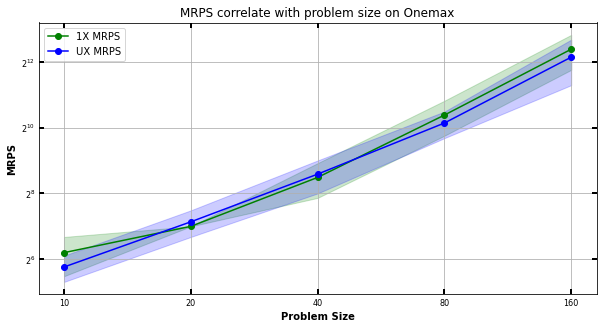

In [129]:
fig = plt.figure(figsize=(10,5))
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12


ax = plt.subplot(111)
ax.plot(y[0:len(x1)] , x1, "go-", label = '1X MRPS')
#ax.plot(y, x1, marker="o", label = '1X MRPS')
ax.fill_between(y[0:len(x1)], x1 + x1_err, x1 - x1_err, alpha=0.2, color='green')
ax.plot(y[0:len(x2)] , x2, "bo-", label = 'UX MRPS')
#ax.plot(y, x2, marker="o", label = 'UX MRPS')
ax.fill_between(y[0:len(x2)], x2 + x2_err, x2 - x2_err, alpha=0.2, color = 'blue')


ax.set_xscale('log', basex = 2)
ax.set_xticks([10, 20, 40, 80, 160])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_yscale('log', basey=2)
ax.minorticks_on() 
ax.tick_params(axis="both", which="major",direction="in",length=5,width=2,top="on",right="on")
ax.tick_params(axis="both", which="minor",direction="in",length=2,width=1,top="on",right="on")

ax.set_title("MRPS correlate with problem size on Onemax")
ax.set_xlabel("Problem Size")
ax.set_ylabel("MRPS")

ax.grid()
plt.legend(loc = 'best')
plt.show()


fig.savefig("OneMax_Compare_MRPS_UX_1X.png",format="png", dpi=300)



In [120]:
y = np.array([10, 20, 40, 80, 160])

x1 = np.array(table1[('sGA-1X', '#Evaluations')])
x1_err = np.array(table1[('sGA-1X', 'std(#Evaluations)')])

x2 = np.array(table1[('sGA-UX', '#Evaluations')])
x2_err = np.array(table1[('sGA-UX', 'std(#Evaluations)')])

<ipython-input-128-7bcf6966f591>:23: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale('log', basex = 2)
<ipython-input-128-7bcf6966f591>:26: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale('log', basey=2)


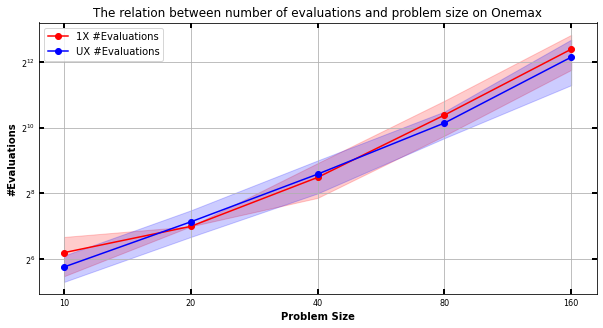

In [128]:
fig = plt.figure(figsize=(10,5))
plt.rcParams["font.size"] = 18
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12

ax = plt.subplot(111)
ax.plot(y[0:len(x1)] , x1, "ro-", label = '1X #Evaluations')
#ax.plot(y, x1, marker="o", label = '1X MRPS')
ax.fill_between(y[0:len(x1)], x1 + x1_err, x1 - x1_err, alpha=0.2, color='red')
ax.plot(y[0:len(x2)] , x2, "bo-", label = 'UX #Evaluations')
#ax.plot(y, x2, marker="o", label = 'UX MRPS')
ax.fill_between(y[0:len(x2)], x2 + x2_err, x2 - x2_err, alpha=0.2, color='blue')


ax.set_xscale('log', basex = 2)
ax.set_xticks([10, 20, 40, 80, 160])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_yscale('log', basey=2)
ax.minorticks_on() 
ax.tick_params(axis="both", which="major",direction="in",length=5,width=2,top="on",right="on")
ax.tick_params(axis="both", which="minor",direction="in",length=2,width=1,top="on",right="on")

ax.set_title("The relation between number of evaluations and problem size on Onemax")
ax.set_xlabel("Problem Size")
ax.set_ylabel("#Evaluations")

ax.grid()
plt.legend(loc = 'best')
plt.show()


fig.savefig("OneMax_Compare_Evaluations_UX_1X.png",format="png", dpi=600)



### Trap-k part
This is run on Google Colab so no available printing. I have stored the output data in [Trap-K](./Trap_k.pkl)

In [52]:
header = pd.MultiIndex.from_product([['sGA-1X','sGA-UX'],
                                     ['MRPS', 'std(MRPS)', '#Evaluations', 'std(#Evaluations']],
                                    names=['type','statistic'])
MSSV = 19520208
sizes = [10, 20, 40, 80, 160]
table2 = pd.DataFrame(index=sizes, columns=header)

In [ ]:
vars = ['UX'] # Two types of crossover
upperT = []
aveT = []
for var in vars:

    mean_upper = []
    mean_eva = []

    for problem_size in sizes:
        temp_upper = []
        temp_ave = []

        for i in range(0, 91, 10):
            upper, average_number_of_evaluations = MRPS(problem_size, MSSV + i, MSSV + i + 9, 
                                                        trap = False, ctype = var, len_traps = 5)
            temp_upper.append(upper)
            temp_ave.append(average_number_of_evaluations)

        temp1 = calculateAverage(temp_upper)
        temp2 = calculateAverage(temp_ave)
        print(temp1, temp2)
        mean_upper.append(temp1)
        mean_eva.append(temp2)

        upperT.append(np.std(temp_upper))
        aveT.append(np.std(temp_ave))

    table2[('sGA-UX', 'MRPS')] = mean_upper
    table2[('sGA-UX', '#Evaluations')] = mean_eva
    table2[('sGA-UX', 'std(MRPS)')] = upperT
    table2[('sGA-UX', 'std(#Evaluations)')] = aveT


In [ ]:
vars = ['1X'] # Two types of crossover
upperT = []
aveT = []
for var in vars:
    

    mean_upper = []
    mean_eva = []

    for problem_size in sizes:
        temp_upper = []
        temp_ave = []

        for i in range(0, 91, 10):
            upper, average_number_of_evaluations = MRPS(problem_size, MSSV + i, MSSV + i + 9, 
                                                        trap = False, ctype = var, len_traps = 5)
            temp_upper.append(upper)
            temp_ave.append(average_number_of_evaluations)

        temp1 = calculateAverage(temp_upper)
        temp2 = calculateAverage(temp_ave)
        print(temp1, temp2)
        mean_upper.append(temp1)
        mean_eva.append(temp2)

        upperT.append(np.std(temp_upper))
        aveT.append(np.std(temp_ave))

    table2[('sGA-1X', 'MRPS')] = mean_upper
    table2[('sGA-1X', '#Evaluations')] = mean_eva
    table2[('sGA-1X', 'std(MRPS)')] = upperT
    table2[('sGA-1X', 'std(#Evaluations)')] = aveT



In [57]:
table2.to_pickle('Trap_k.pkl')

#### Draw for Trap-k function


MRPS plot

In [123]:
table2 = pd.read_pickle('Trap_k.pkl')
y = np.array([10, 20, 40, 80, 160])

x1 = np.array(table2[('sGA-1X', 'MRPS')])
x1_err = np.array(table2[('sGA-1X', 'std(MRPS)')])

x2 = np.array(table2[('sGA-UX', 'MRPS')])
x2_err = np.array(table2[('sGA-UX', 'std(MRPS)')])

<ipython-input-126-4144b696e130>:23: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale('log', basex = 2)
<ipython-input-126-4144b696e130>:26: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale('log', basey=2)


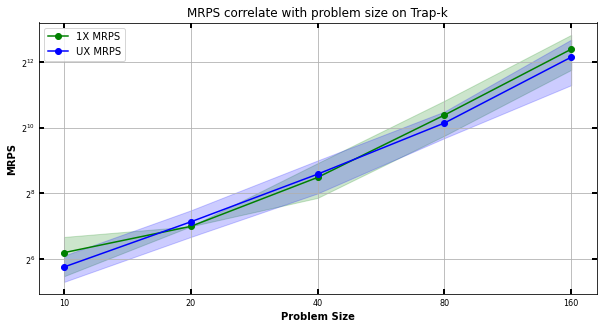

In [126]:
fig = plt.figure(figsize=(10,5))
plt.rcParams["font.size"] = 18
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12

ax = plt.subplot(111)
ax.plot(y[0:len(x1)] , x1, "go-", label = '1X MRPS')
#ax.plot(y, x1, marker="o", label = '1X MRPS')
ax.fill_between(y[0:len(x1)], x1 + x1_err, x1 - x1_err, alpha=0.2, color='green')
ax.plot(y[0:len(x2)] , x2, "bo-", label = 'UX MRPS')
#ax.plot(y, x2, marker="o", label = 'UX MRPS')
ax.fill_between(y[0:len(x2)], x2 + x2_err, x2 - x2_err, alpha=0.2, color = 'blue')


ax.set_xscale('log', basex = 2)
ax.set_xticks([10, 20, 40, 80, 160])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_yscale('log', basey=2)
ax.minorticks_on() 
ax.tick_params(axis="both", which="major",direction="in",length=5,width=2,top="on",right="on")
ax.tick_params(axis="both", which="minor",direction="in",length=2,width=1,top="on",right="on")

ax.set_title("MRPS correlate with problem size on Trap-k")
ax.set_xlabel("Problem Size")
ax.set_ylabel("MRPS")

ax.grid()
plt.legend(loc = 'best')
plt.show()


fig.savefig("Trap_Compare_MRPS_UX_1X.png",format="png", dpi=300)



Evaluations plot

In [ ]:
y = np.array([10, 20, 40, 80, 160])

x1 = np.array(table2[('sGA-1X', '#Evaluations')])
x1_err = np.array(table2[('sGA-1X', 'std(#Evaluations)')])

x2 = np.array(table2[('sGA-UX', '#Evaluations')])
x2_err = np.array(table2[('sGA-UX', 'std(#Evaluations)')])

<ipython-input-127-5abb703b437d>:23: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale('log', basex = 2)
<ipython-input-127-5abb703b437d>:26: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale('log', basey=2)


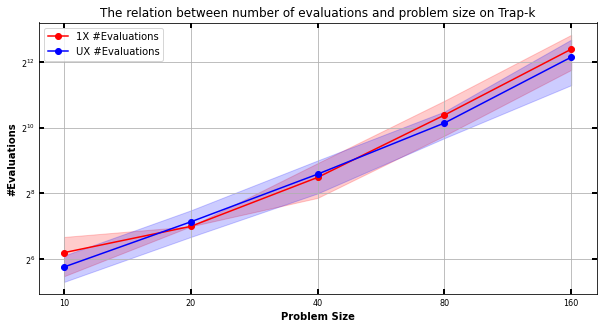

In [127]:
fig = plt.figure(figsize=(10,5))
plt.rcParams["font.size"] = 18
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12

ax = plt.subplot(111)
ax.plot(y[0:len(x1)] , x1, "ro-", label = '1X #Evaluations')
#ax.plot(y, x1, marker="o", label = '1X MRPS')
ax.fill_between(y[0:len(x1)], x1 + x1_err, x1 - x1_err, alpha=0.2, color='red')
ax.plot(y[0:len(x2)] , x2, "bo-", label = 'UX #Evaluations')
#ax.plot(y, x2, marker="o", label = 'UX MRPS')
ax.fill_between(y[0:len(x2)], x2 + x2_err, x2 - x2_err, alpha=0.2, color='blue')


ax.set_xscale('log', basex = 2)
ax.set_xticks([10, 20, 40, 80, 160])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_yscale('log', basey=2)
ax.minorticks_on() 
ax.tick_params(axis="both", which="major",direction="in",length=5,width=2,top="on",right="on")
ax.tick_params(axis="both", which="minor",direction="in",length=2,width=1,top="on",right="on")

ax.set_title("The relation between number of evaluations and problem size on Trap-k")
ax.set_xlabel("Problem Size")
ax.set_ylabel("#Evaluations")

ax.grid()
plt.legend(loc = 'best')
plt.show()


fig.savefig("TRap_Compare_Evaluations_UX_1X.png",format="png", dpi=600)

